# Model Development

In this notebook, we will develop a Kriging model using the `NYS Oil & Gas Wells` to predict optimal drilling locations for oil and gas in **New York State**. Using geological and production data, we will explore spatial interpolation techniques to accurately estimate potential production sites. The process will involve building the Kriging model and refining it through regularization and hyperparameter tuning.

By the end of this notebook, we will have established a robust model ready for evaluation, aiming to identify the most effective approach for predicting where to drill for oil and gas.

### Loading Tools and Data

count    3,691.00
mean    13,417.05
std      8,529.29
min      2,168.00
25%      5,756.00
50%     11,598.00
75%     20,423.50
max     31,710.00
Name: gas_prod, dtype: float64
------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3691 entries, 0 to 3690
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gas_prod   3691 non-null   float64
 1   well       3691 non-null   object 
 2   status     3691 non-null   object 
 3   depth      3691 non-null   float64
 4   elevation  3691 non-null   float64
 5   longitude  3691 non-null   float64
 6   latitude   3691 non-null   float64
 7   field      3691 non-null   object 
 8   geology    3691 non-null   object 
dtypes: float64(5), object(4)
memory usage: 259.6+ KB
None


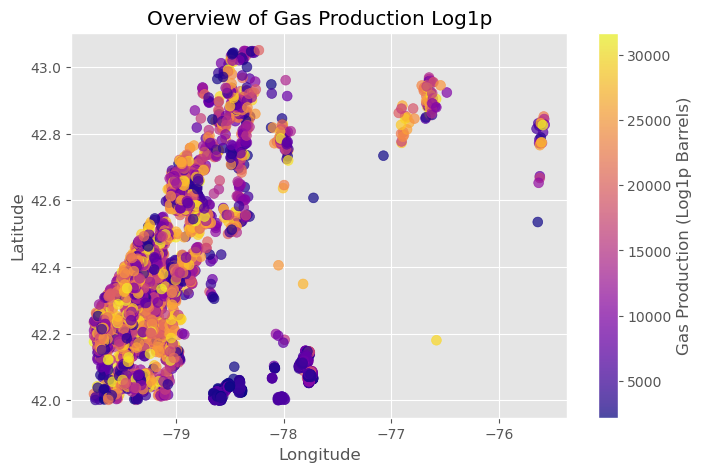

,gas_prod,well,status,depth,elevation,longitude,latitude,field,geology
0,"5,455.00",gas development,plugged abandoned,"1,294.00",851.00,-78.48,42.94,Alden-Lancaster,Medina
1,"4,741.00",gas development,plugged abandoned,"1,818.00",535.00,-76.66,42.89,West Auburn,Queenston
2,"28,116.00",gas development,inactive,"1,425.00",640.00,-78.92,42.73,Orchard Park-Hamburg,Medina
3,"4,226.00",gas extension,plugged abandoned,"3,450.00","1,283.00",-79.31,42.27,Cassadaga Creek,Upper Devonian
4,"4,966.00",oil wildcat,active,"4,500.00","1,780.00",-79.59,42.05,Clymer,Bass Island


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from scipy.signal import detrend
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, ParameterSampler, ParameterGrid
from skgstat import Variogram, DirectionalVariogram, OrdinaryKriging
from skgstat.util.cross_validation import jacknife
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import dill as pickle
import pprint, warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

df = pd.read_csv('../data/clean_gaswells.csv')
df_saved = df.copy()

print(df['gas_prod'].describe())
print('------------------------')
print(df.info())

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['longitude']), np.array(df['latitude']), 
                       s=50, c=np.array(df['gas_prod']), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Log1p Barrels)')
plt.title('Overview of Gas Production Log1p')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

df.head()

## Detrend

### Finding the Trend

#### Base Regular Variogram| - No Detrend

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 3.002772436523433,
 'normalized_sill': 6969974250872130.0,
 'normalized_nugget': 0,
 'effective_range': 0.7051774826247071,
 'sill': 77082745.90264602,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


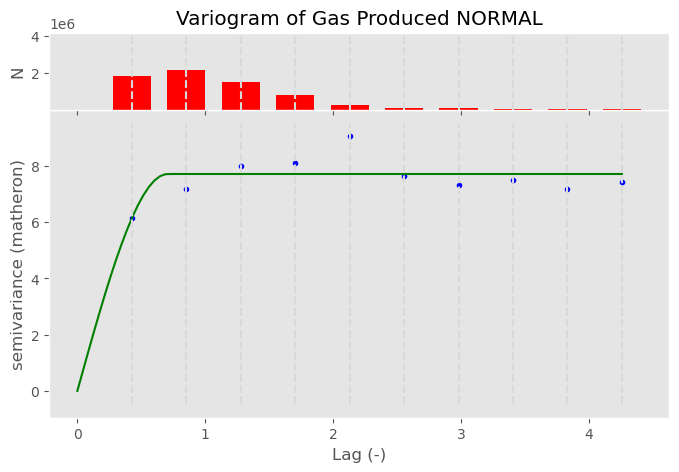

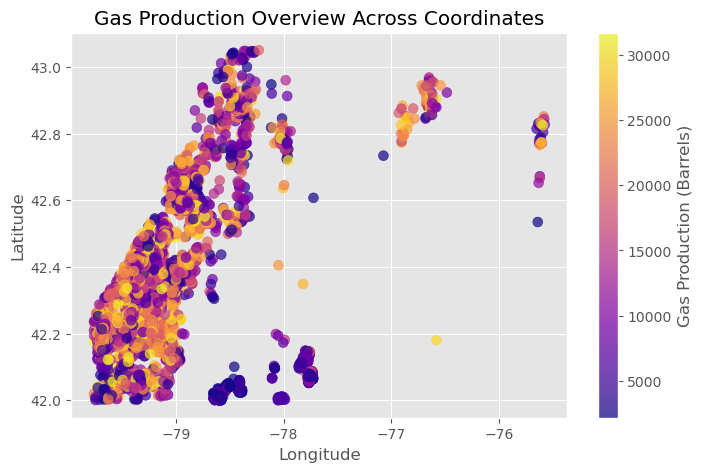

In [2]:
df = df_saved.copy()
coordinates = np.array(df[['longitude','latitude']].values)
target = np.array(df['gas_prod'].values)

test_variogram = Variogram(
    coordinates=coordinates, 
    values=target)
pprint.pp(test_variogram.describe())

test_variogram.plot()
plt.title('Variogram of Gas Produced NORMAL')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(coordinates[:,0], coordinates[:,1], 
                       s=50, c=target, cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Gas Production Overview Across Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Base Directional Variogram - No Detrend

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 4.213703923386633,
 'normalized_sill': 8510803381464747.0,
 'normalized_nugget': 0,
 'effective_range': 1.0339994721841113,
 'sill': 81027977.17911619,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


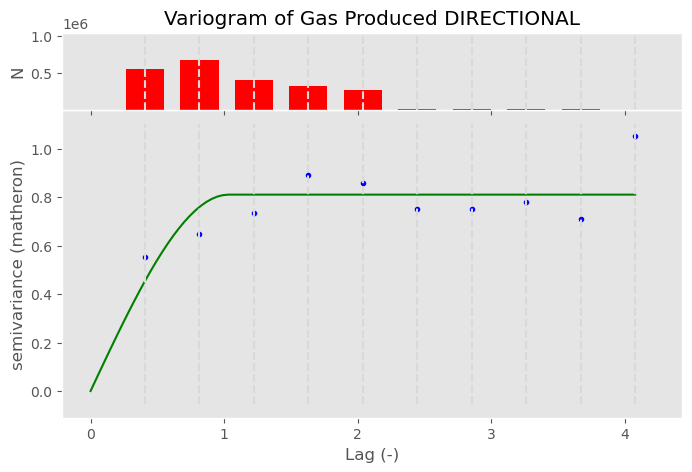

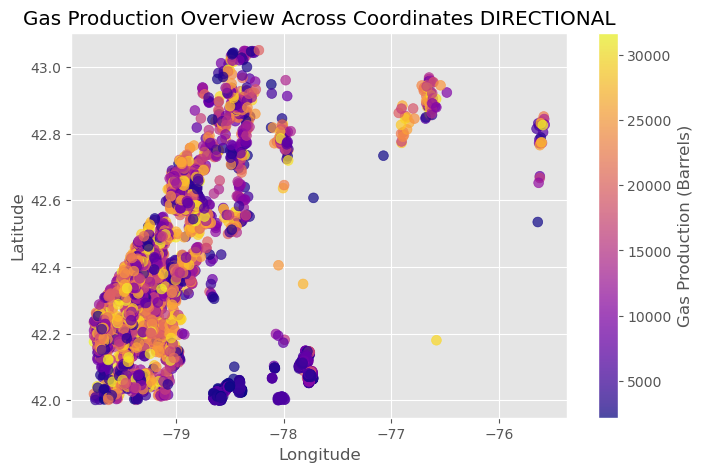

In [3]:
df = df_saved.copy()
coordinates = np.array(df[['longitude','latitude']].values)
target = np.array(df['gas_prod'].values)

test_variogram = DirectionalVariogram(
    coordinates=coordinates, 
    values=target)
pprint.pp(test_variogram.describe())

test_variogram.plot()
plt.title('Variogram of Gas Produced DIRECTIONAL')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(coordinates[:,0], coordinates[:,1], 
                       s=50, c=target, cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Gas Production Overview Across Coordinates DIRECTIONAL')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Linear Regression Detrended Variogram

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 13.512247961805793,
 'normalized_sill': 1.888716080695915e+16,
 'normalized_nugget': 0,
 'effective_range': 3.315766250918441,
 'sill': 114293914.49676274,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


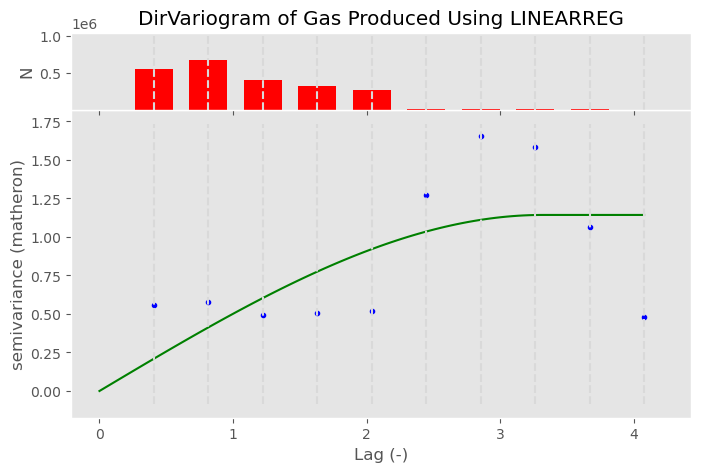

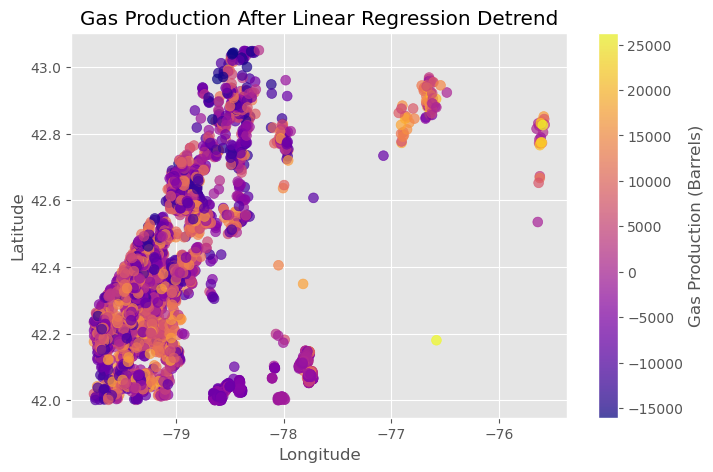

In [4]:
df = df_saved.copy()
coordinates = np.array(df[['longitude','latitude']].values)
target = np.array(df['gas_prod'].values)

reg = LinearRegression().fit(coordinates, target)
trend = reg.predict(coordinates)
detrended_gas = target - trend

test_variogram = DirectionalVariogram(
    coordinates=coordinates,
    values=detrended_gas)
pprint.pp(test_variogram.describe())

test_variogram.plot()
plt.title('DirVariogram of Gas Produced Using LINEARREG')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(coordinates[:,0], coordinates[:,1], 
                       s=50, c=detrended_gas, cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Gas Production After Linear Regression Detrend')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Polynomial Regression Detrended Variogram

{'dist_func': 'euclidean',
 'effective_range': 3.526180886825677,
 'estimator': 'matheron',
 'kwargs': {},
 'model': 'spherical',
 'normalized_effective_range': 14.369719363592369,
 'normalized_nugget': 0,
 'normalized_sill': 8482806636608083.0,
 'nugget': 0,
 'params': {'bin_func': 'even',
            'dist_func': 'euclidean',
            'estimator': 'matheron',
            'fit_method': 'trf',
            'fit_sigma': None,
            'maxlag': None,
            'model': 'spherical',
            'n_lags': 10,
            'normalize': False,
            'use_nugget': False,
            'verbose': False},
 'sill': 85987858.6058897}


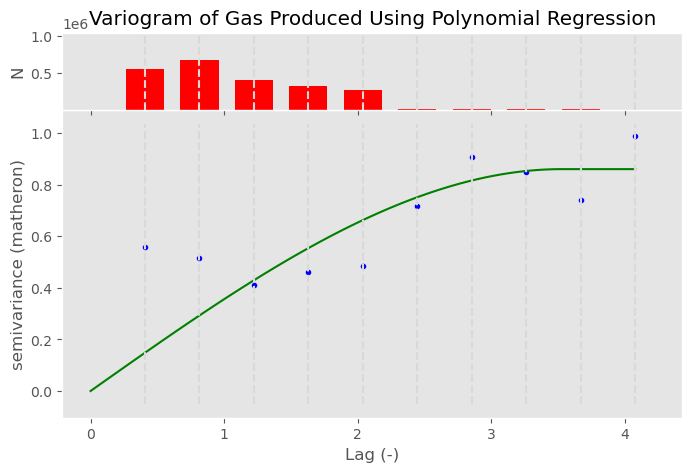

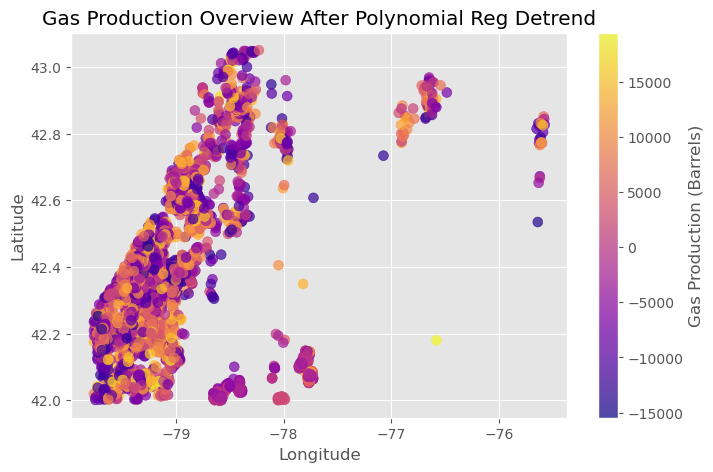

In [5]:
df = df_saved.copy()
coordinates = np.array(df[['longitude','latitude']].values)
target = np.array(df['gas_prod'].values)

poly = PolynomialFeatures(degree=3, include_bias=False)
coordinates_poly = poly.fit_transform(coordinates)

reg = LinearRegression().fit(coordinates_poly, target)
trend = reg.predict(coordinates_poly)
detrended_gas = target - trend

test_variogram = DirectionalVariogram(
    coordinates=coordinates, 
    values=detrended_gas)
pprint.pprint(test_variogram.describe())

test_variogram.plot()
plt.title('Variogram of Gas Produced Using Polynomial Regression')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(coordinates[:,0], coordinates[:,1], 
                       s=50, c=detrended_gas, cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Gas Production Overview After Polynomial Reg Detrend')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

### Detrend Preprocessing

##### `Polynomial regression was able to better capture the complex trend of the data more effectively leading to more stationary residuals, which is crucial for accurate kriging. Although the sill is slightly higher than the base directional variogram model meaning the variance is slightly higher with the residuals, but we were able to capture the stationarity through polynomial regression, key to kriging.`

#### Detrend Build

In [6]:
df = df_saved.copy()
coordinates = np.array(df[['longitude','latitude']].values)
target = np.array(df['gas_prod'].values)

poly = PolynomialFeatures(degree=3, include_bias=False)
coordinates_poly = poly.fit_transform(coordinates)

reg = LinearRegression().fit(coordinates_poly, target)
trend = reg.predict(coordinates_poly)
detrended_gas = target - trend

df_detrended = df_saved.copy()
df_detrended['gas_prod'] = detrended_gas
print(df_detrended.describe())

        gas_prod    depth  elevation  longitude  latitude
count   3,691.00 3,691.00   3,691.00   3,691.00  3,691.00
mean        0.00 2,720.24   1,477.53     -78.79     42.33
std     7,447.12 1,061.56     468.29       0.68      0.28
min   -15,466.12   181.00       8.00     -79.76     42.00
25%    -5,118.49 1,838.00   1,150.00     -79.30     42.08
50%      -879.99 2,535.00   1,511.00     -78.93     42.27
75%     5,248.61 3,670.00   1,785.50     -78.43     42.53
max    19,445.32 6,412.00   2,398.00     -75.58     43.05


In [7]:
df_detrended = df_detrended[['gas_prod','depth','elevation','longitude','latitude',
              'well','status','field','geology']]
df_detrended.head()

,gas_prod,depth,elevation,longitude,latitude,well,status,field,geology
0,"-8,186.21","1,294.00",851.00,-78.48,42.94,gas development,plugged abandoned,Alden-Lancaster,Medina
1,"-12,104.63","1,818.00",535.00,-76.66,42.89,gas development,plugged abandoned,West Auburn,Queenston
2,"14,721.52","1,425.00",640.00,-78.92,42.73,gas development,inactive,Orchard Park-Hamburg,Medina
3,"-12,794.81","3,450.00","1,283.00",-79.31,42.27,gas extension,plugged abandoned,Cassadaga Creek,Upper Devonian
4,"-9,290.20","4,500.00","1,780.00",-79.59,42.05,oil wildcat,active,Clymer,Bass Island


#### Detrend Plot

{'dist_func': 'euclidean',
 'effective_range': 3.526180886825677,
 'estimator': 'matheron',
 'kwargs': {},
 'model': 'spherical',
 'normalized_effective_range': 14.369719363592369,
 'normalized_nugget': 0,
 'normalized_sill': 8482806636608083.0,
 'nugget': 0,
 'params': {'bin_func': 'even',
            'dist_func': 'euclidean',
            'estimator': 'matheron',
            'fit_method': 'trf',
            'fit_sigma': None,
            'maxlag': None,
            'model': 'spherical',
            'n_lags': 10,
            'normalize': False,
            'use_nugget': False,
            'verbose': False},
 'sill': 85987858.6058897}


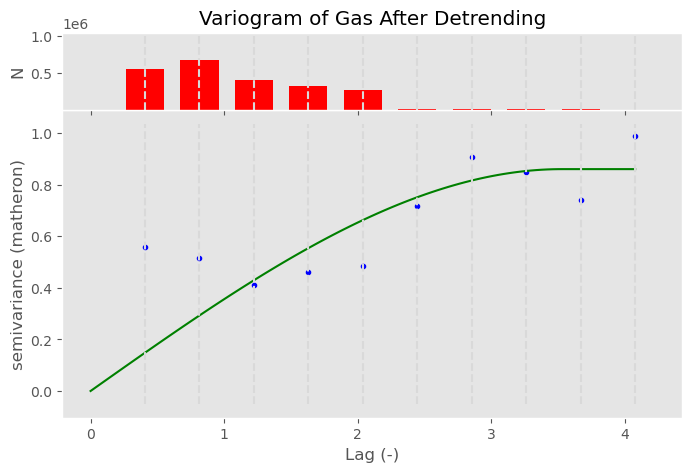

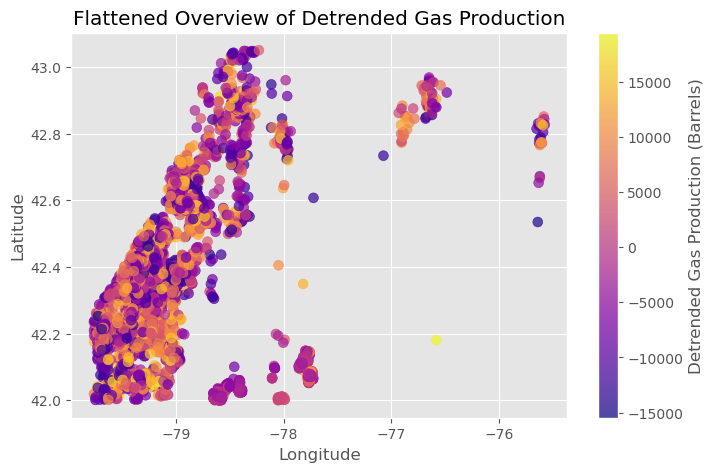

In [8]:
df = df_detrended.copy()
coordinates = np.array(df[['longitude','latitude']].values)
target = np.array(df['gas_prod'].values)

detrend_variogram = DirectionalVariogram(
    coordinates=coordinates, 
    values=target)
pprint.pprint(detrend_variogram.describe())

detrend_variogram.plot()
plt.title('Variogram of Gas After Detrending')

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(df['longitude'], df['latitude'], 
                       s=50, c=df['gas_prod'], cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Detrended Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

## Preprocessing by Encoding Data

#### Encoding

In [9]:
df = df_detrended.copy()
target = df['gas_prod']

numerical = ['gas_prod','depth','elevation','longitude','latitude']
categorical = ['well','status','field','geology']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical),
        ('cat', OneHotEncoder(sparse_output=False), categorical)])

df_transformed = preprocessor.fit_transform(df)
df_transformed = pd.DataFrame(df_transformed, columns=preprocessor.get_feature_names_out())
df_transformed.to_csv('../data/encoded_gaswells.csv', index=False)
print(df_transformed['num__gas_prod'].describe())
df_transformed

count     3,691.00
mean          0.00
std       7,447.12
min     -15,466.12
25%      -5,118.49
50%        -879.99
75%       5,248.61
max      19,445.32
Name: num__gas_prod, dtype: float64


,num__gas_prod,num__depth,num__elevation,num__longitude,num__latitude,cat__well_gas development,cat__well_gas extension,cat__well_gas wildcat,cat__well_oil development,cat__well_oil wildcat,cat__status_active,cat__status_drilling complete,cat__status_inactive,cat__status_plugged abandoned,cat__status_shut in,cat__field_Akron,cat__field_Alden-Lancaster,cat__field_Allen,cat__field_Andover,cat__field_Ashford,cat__field_Attica,cat__field_Auburn,cat__field_Beaver Meadow - Vernon pool,cat__field_Beech Hill,cat__field_Beech Hill-Independence,cat__field_Bethany,cat__field_Bradford,cat__field_Bradley Brook,cat__field_Bradley Brook - Herkimer pool,cat__field_Brant-Eden,cat__field_Buffalo,cat__field_Buffalo Creek,cat__field_Busti,cat__field_Cagwin,cat__field_Cascade Brook,cat__field_Cassadaga Creek,cat__field_Castile,cat__field_Chaffee-Arcade,cat__field_Chestnut Ridge,cat__field_Chipmunk,cat__field_Clymer,cat__field_Concord,cat__field_Corbin Hill,cat__field_Cowlesville,cat__field_Danley Corners,cat__field_Dansville,cat__field_Dayton,cat__field_Dutch Hollow,cat__field_East Aurora,cat__field_East Otto,cat__field_Ellery,cat__field_Ellicotville,cat__field_Elma,cat__field_Fayette-Waterloo,cat__field_Five Mile,cat__field_Folsom Creek,cat__field_Four Mile,cat__field_Fulmer Valley,cat__field_Gerry-Charlotte,cat__field_Glenwood,cat__field_Gordon Brook,cat__field_Harmony,cat__field_Hog Hollow,cat__field_Huron Creek,cat__field_Indian Falls,cat__field_Java,cat__field_Karr Valley,cat__field_Lakeshore,cat__field_Lakeview,cat__field_Lebanon,cat__field_Leicester,cat__field_Longhorn - Hamilton Pool,cat__field_Mud Creek,cat__field_New Field Wildcat,cat__field_North Collins,cat__field_North Harmony,cat__field_North Penn Yan,cat__field_Olean,cat__field_Orchard Park-Hamburg,cat__field_Richburg,cat__field_Sardinia,cat__field_Sharon,cat__field_Sheldon,cat__field_Silver Lake,cat__field_Tozier's Corners,cat__field_Uhley Corners-Caledonia,cat__field_Utley Brook,cat__field_Van Etten,cat__field_Wales,cat__field_West Auburn,cat__field_West Seneca,cat__field_West Union,cat__geology_Akron,cat__geology_Bass Island,cat__geology_Bradford,cat__geology_Bradford & Chipmunk,cat__geology_Bradford 1st & Chipmunk,cat__geology_Bradford 2nd & 3rd,cat__geology_Bradford Second,cat__geology_Bradford Third,cat__geology_Chipmunk,cat__geology_Chipmunk & Bradford 2nd,cat__geology_Chipmunk & Bradford 3rd,cat__geology_Chipmunk & Harrisburg,"cat__geology_Chipmunk, Bradford 1st & 2nd","cat__geology_Chipmunk, Bradford 1st,2nd,3rd","cat__geology_Chipmunk, Bradford 2nd & 3rd",cat__geology_Clinton,cat__geology_Devonian Shale,cat__geology_Fulmer Valley,cat__geology_Glade,cat__geology_Grimsby,cat__geology_Hamilton,cat__geology_Herkimer,cat__geology_Herkimer-Oneida,cat__geology_Marcellus,cat__geology_Medina,cat__geology_Not Applicable,cat__geology_Oneida,cat__geology_Oneida-Oswego,cat__geology_Onondaga,cat__geology_Onondaga-Bass Island,cat__geology_Oriskany,cat__geology_Penny & Fulmer Valley,cat__geology_Queenston,cat__geology_Retsof,cat__geology_Richburg,cat__geology_Richburg-Waugh & Porter,cat__geology_Surficial,cat__geology_Theresa,cat__geology_Tully,cat__geology_Upper Devonian,cat__geology_Utica,cat__geology_Vernon,cat__geology_Waugh & Porter,cat__geology_Whirlpool
0,"-8,186.21","1,294.00",851.00,-78.48,42.94,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,"-12,104.63","1,818.00",535.00,-76.66,42

#### Model Prep

In [10]:
df = pd.read_csv('../data/encoded_gaswells.csv')
print(f'Data Shape: {df.shape}')

coords = np.array(df[['num__longitude', 'num__latitude']].values)
vals = np.array(df['num__gas_prod'].values)

x = coords[:, 0]
y = coords[:, 1]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]

x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

print(f'\
\nSplit Shapes\n------------\n\
coords:   {coords.shape}\n\
target:   {vals.shape}\n\
gridx:    {xx.shape}\n\
gridy:    {yy.shape}\n\
\nArray Values\n----------------\n\
coordinates: \n{coords}\n\
target:      \n{vals}')

Data Shape: (3691, 136)

Split Shapes
------------
coords:   (3691, 2)
target:   (3691,)
gridx:    (100, 100)
gridy:    (100, 100)

Array Values
----------------
coordinates: 
[[-78.48139   42.93727 ]
 [-76.66245   42.89157 ]
 [-78.92266   42.73046 ]
 ...
 [-76.626547  42.861386]
 [-76.583833  42.878911]
 [-77.074521  42.733755]]
target:      
[ -8186.20778596 -12104.6289016   14721.52188027 ...  -3070.98373783
  -6707.03879416 -13149.34362781]


## Ordinary Kriging

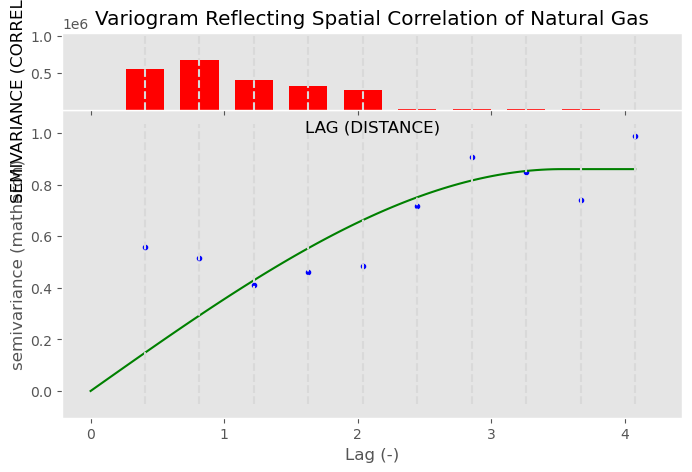

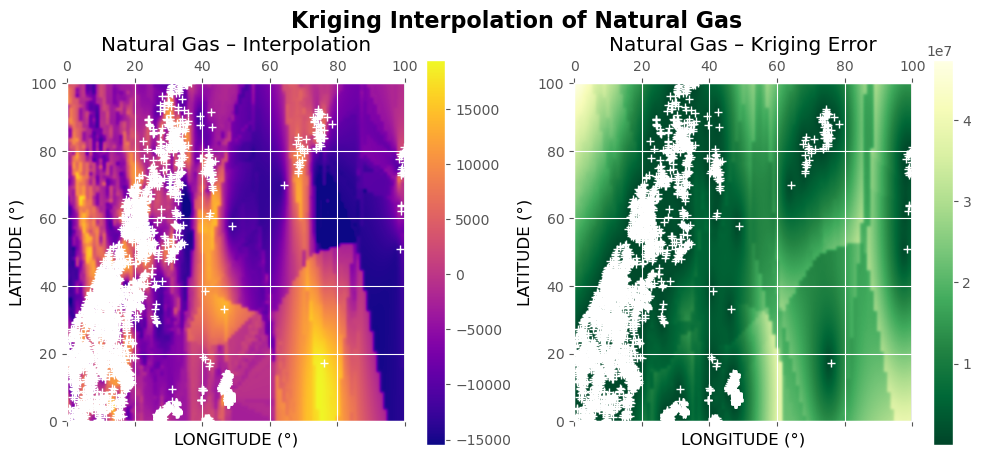

In [11]:
V = DirectionalVariogram(
    coordinates=coords,
    values=vals.flatten())

V.plot()
plt.title('Variogram Reflecting Spatial Correlation of Natural Gas')
plt.xlabel('LAG (DISTANCE)', color='black')
plt.ylabel('SEMIVARIANCE (CORRELATION)', color='black')
plt.savefig('../images/base_variogram.png')

kriging = OrdinaryKriging(V)
field = kriging.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = kriging.sigma.reshape(xx.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
gas_interp = ax1.matshow(field.T, origin='lower', cmap='plasma', 
                   interpolation='gaussian',
                   vmin=vals.min(), vmax=vals.max())
ax1.set_title('Natural Gas – Interpolation')
ax1.plot(x_, y_, '+w')
ax1.set_xlabel('LONGITUDE (°)', color='black')
ax1.set_ylabel('LATITUDE (°)', color='black')
ax1.set_xlim((0, 100))
ax1.set_ylim((0, 100))
plt.colorbar(gas_interp, ax=ax1)

gas_error = ax2.matshow(s2.T, origin='lower', cmap='YlGn_r',
                   interpolation='gaussian')
ax2.set_title('Natural Gas – Kriging Error')
ax2.plot(x_, y_, '+w')
ax2.set_xlabel('LONGITUDE (°)', color='black')
ax2.set_ylabel('LATITUDE (°)', color='black')
ax2.set_xlim((0, 100))
ax2.set_ylim((0, 100))
plt.colorbar(gas_error, ax=ax2)

plt.suptitle('Kriging Interpolation of Natural Gas\n', fontsize=16, fontweight='bold')
plt.show()
fig.savefig('../images/base_results.png')
plt.close()

with open('../model/base_model.pkl', 'wb') as file:
    pickle.dump(kriging, file)

## Hyperparameter Tuning

In [12]:
# param_dist = {
#     'min_points': range(10, 21),
#     'max_points': range(20, 41),
#     'mode': ['exact', 'estimate'],
#     'precision': range(75, 126),
#     'n_lags': range(10, 21),
#     'model': ['spherical', 'exponential', 'gaussian'],
#     'azimuth': [0, 45, 90, 135, 180],
#     'tolerance': [30.0, 45.0, 60.0],
#     'bandwidth': ['q33', 'q50', 'q67']}

# randsearch_iter = 20
# randsearch_params = list(ParameterSampler(param_dist, n_iter=randsearch_iter, random_state=42))

# best_params = None
# best_score = float('inf')

# for params in randsearch_params:
#     V = DirectionalVariogram(
#         coordinates=coords,
#         values=vals.flatten(),
#         model=params['model'],
#         n_lags=params['n_lags'],
#         azimuth=params['azimuth'],
#         tolerance=params['tolerance'],
#         bandwidth=params['bandwidth'])

#     kriging = OrdinaryKriging(
#         V,
#         min_points=params['min_points'],
#         max_points=params['max_points'],
#         mode=params['mode'],
#         precision=params['precision'])

#     score = jacknife(V, metric='rmse')
#     if score < best_score:
#         best_score = score
#         best_params = params

# print('RandomizedSearch')
# print(best_params)
# print(best_score)

# param_grid = {
#     'min_points': [best_params['min_points'] - 2, 
#                    best_params['min_points'], 
#                    best_params['min_points'] + 2],
#     'max_points': [best_params['max_points'] - 5, 
#                    best_params['max_points'], 
#                    best_params['max_points'] + 5],
#     'precision': [best_params['precision'] - 10, 
#                   best_params['precision'], 
#                   best_params['precision'] + 10],
#     'n_lags': [best_params['n_lags'] - 2, 
#                best_params['n_lags'], 
#                best_params['n_lags'] + 2],
#     'azimuth': [best_params['azimuth']],
#     'tolerance': [best_params['tolerance']],
#     'bandwidth': [best_params['bandwidth']],
#     'mode': [best_params['mode']],
#     'model': [best_params['model']]}

# gridsearch_params = list(ParameterGrid(param_grid))
# best_params = None
# best_score = float('inf')

# for params in gridsearch_params:
#     V = DirectionalVariogram(
#         coordinates=coords,
#         values=vals.flatten(),
#         model=params['model'],
#         n_lags=params['n_lags'],
#         azimuth=params['azimuth'],
#         tolerance=params['tolerance'],
#         bandwidth=params['bandwidth'])

#     kriging = OrdinaryKriging(
#         V,
#         min_points=params['min_points'],
#         max_points=params['max_points'],
#         mode=params['mode'],
#         precision=params['precision'])

#     score = jacknife(V, metric='rmse')
#     if score < best_score:
#         best_score = score
#         best_params = params

# print('GridSearch')
# print(best_params)
# print(best_score)

## Tuned Model

In [13]:
# tuned_variogram = DirectionalVariogram(
#     coordinates=coords,
#     values=vals.flatten(),
#     model=best_params['model'],
#     n_lags=best_params['n_lags'],
#     azimuth=best_params['azimuth'],
#     tolerance=best_params['tolerance'],
#     bandwidth=best_params['bandwidth'])

# tuned_variogram.plot()
# plt.title('Variogram of Gas')
# plt.savefig('../images/tuned_variogram.png')

# tuned_kriging = OrdinaryKriging(
#     tuned_variogram,
#     min_points=best_params['min_points'],
#     max_points=best_params['max_points'],
#     mode=best_params['mode'],
#     precision=best_params['precision'])

# field = tuned_kriging.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
# s2 = tuned_kriging.sigma.reshape(xx.shape)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# gas_interp = ax1.matshow(field.T, origin='lower', cmap='plasma', 
#                    interpolation='gaussian',
#                    vmin=vals.min(), vmax=vals.max())
# ax1.set_title('Natural Gas – Interpolation')
# ax1.plot(x_, y_, '+w')
# ax1.set_xlabel('Longitude (°)')
# ax2.set_ylabel('Latitude (°)')
# ax1.set_xlim((0, 100))
# ax1.set_ylim((0, 100))
# plt.colorbar(gas_interp, ax=ax1)

# gas_error = ax2.matshow(s2.T, origin='lower', cmap='YlGn_r',
#                    interpolation='gaussian')
# ax2.set_title('Natural Gas – Kriging Error')
# ax2.plot(x_, y_, '+w')
# ax2.set_xlabel('Longitude (°)')
# ax2.set_ylabel('Latitude (°)')
# ax2.set_xlim((0, 100))
# ax2.set_ylim((0, 100))
# plt.colorbar(gas_error, ax=ax2)

# plt.suptitle('Kriging Interpolation of Natural Gas', fontsize=15)
# plt.show()
# fig.savefig('../images/base_results.png')
# plt.close()

# with open('../model/tuned_model.pkl', 'wb') as file:
#     pickle.dump(tuned_kriging, file)

In [14]:
# ok3d = OrdinaryKriging3D(
#     x_train,
#     y_train,
#     h_train,
#     v_train,
#     variogram_model='spherical',
#     verbose=True,
#     enable_plotting=True,
#     pseudo_inv=True,
#     pseudo_inv_type='pinv'
# )

# z_train3d, s2_train3d = ok3d.execute("grid", gridx_train, gridy_train, gridh_train)
# pred, error = ok3d.execute('points', x_test, y_test, h_test)

# rmse = np.sqrt(mean_squared_error(v_test, pred))
# mae = mean_absolute_error(v_test, pred)
# r2 = r2_score(v_test, pred)

# print('\n------------\n')
# print("RMSE:", round(rmse,3))
# print("MAE:", round(mae,3))
# print("R2:", round(r2,3))
# print('\n------------\n')

# with open('../model/kriging3d.pkl', 'wb') as file:
#     pickle.dump(ok3d, file)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
# slice_index = z_train3d.shape[2] // 2

# im1 = ax1.imshow(z_train3d[:,:,slice_index], cmap='plasma', interpolation='bilinear', vmin=z_train3d.min(), vmax=z_train3d.max(),
#                  extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
# ax1.set_title('Kriging Interpolation (Train)')
# ax1.plot(x_train, y_train, 'w+')
# ax1.set_xlabel('Longitude')
# ax1.set_ylabel('Latitude')
# plt.colorbar(im1, ax=ax1, label='Gas Production')

# im2 = ax2.imshow(s2_train3d[:,:,slice_index], cmap='YlGn_r', interpolation='bilinear',
#                  extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
# ax2.set_title('Kriging Error (Train)')
# ax2.plot(x_train, y_train, 'w+')
# ax2.set_xlabel('Longitude')
# ax2.set_ylabel('Latitude')
# plt.colorbar(im2, ax=ax2, label='Error')

# plt.show()
# plt.close()

## Hyperparameter Tuning

In [15]:
# param_grid = {
#     'method': ['ordinary3d'],
#     'variogram_model': ['linear', 'power', 'gaussian', 'spherical', 'exponential'],
#     # 'nlags': [6, 10, 15],
#     # 'weight': [True, False],
#     # 'anisotropy_scaling': [(1.0, 1.5), (1.5, 2.0)],
#     # 'anisotropy_angle': [(0.0, 30.0, 60.0), (30.0, 45.0, 60.0)],
#     # 'exact_values': [True, False],
#     # 'pseudo_inv': [True, False],
#     # 'pseudo_inv_type': ['pinv', 'pinvh'],
#     # 'drift_terms': [None, ['regional_linear']] 
# }

# coordinates_train = np.vstack((x_train, y_train, h_train)).T
# coordinates_test = np.vstack((x_test, y_test, h_test)).T

# tuning = GridSearchCV(
#     Krige(), 
#     param_grid, 
#     cv=5, 
#     scoring='neg_root_mean_squared_error',
#     verbose=3, 
#     return_train_score=True,
#     n_jobs=-1 )

# tuning.fit(X=coordinates_train, y=v_train)

# best_params = tuning.best_params_
# best_score = tuning.best_score_
# best_model = tuning.best_estimator_

# pprint.pp(best_params, best_score)

# best_model.fit(coordinates_train, v_train)
# z_train, s2_train = best_model.execute('grid', gridx_train, gridy_train)
# z_test, s2_test = best_model.execute('grid', gridx_test, gridy_test)
# pred, error = best_model.execute('points', x_test, y_test)

# rmse = np.sqrt(mean_squared_error(v_test, pred))
# mae = mean_absolute_error(v_test, pred)
# r2 = r2_score(v_test, pred)

# print('\n------------\n')
# print("RMSE:", round(rmse, 3))
# print("MAE:", round(mae, 3))
# print("R2:", round(r2, 3))
# print('\n------------\n')

## Script

In [16]:
try:
    print('Script executed successfully.')
except:
    print('FAILED')

Script executed successfully.
